In [1]:
# https://www.8host.com/blog/prognozirovanie-vremennyx-ryadov-s-pomoshhyu-arima-v-python-3/
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [5]:
# 'MS' группирует месячные данные
y = y['co2'].resample('MS').mean()
# bfill значит, что нужно использовать значение до заполнения пропущенных значений
y = y.fillna(y.bfill())
print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64


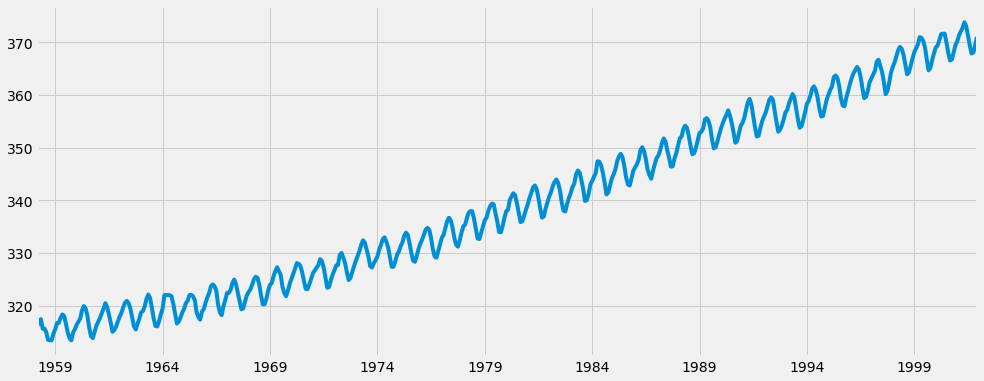

In [6]:
y.plot(figsize=(15, 6))
plt.show()

In [11]:
# Определите p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируйте различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируйте комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]
print("Examples of parameter combinations for Seasonal ARIMA...")
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[1]))
print("SARIMAX: {} x {}".format(pdq[1], seasonal_pdq[2]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[3]))
print("SARIMAX: {} x {}".format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [14]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                y,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False,
                
            )
            results = mod.fit(disp=False)
            print(f"ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}")
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624046018
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.8282341411875
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.711172763751
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.28784156258
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.657897806414
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647913056867
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754448737
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327611404
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067339044
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716928405
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1088.6245117971866
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:869.53624220857
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893602879
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912987615552
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.221119919408
ARIMA

In [17]:
mod = sm.tsa.statespace.SARIMAX(
    y,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
results = mod.fit(disp=False)
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.163      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


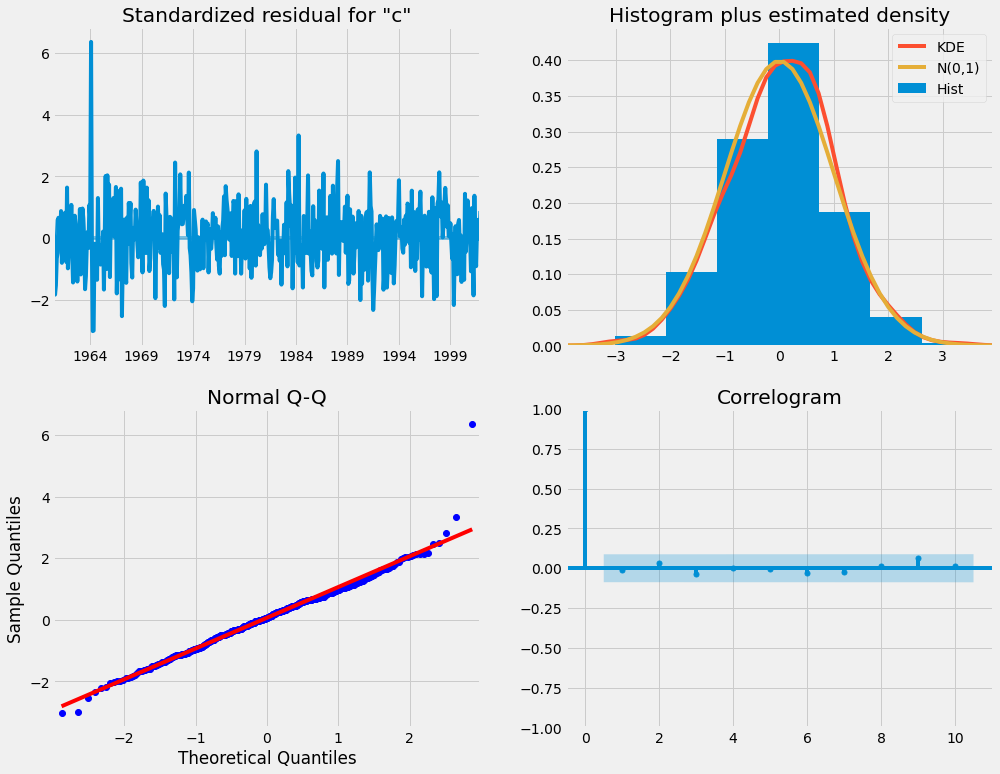

In [18]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [20]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

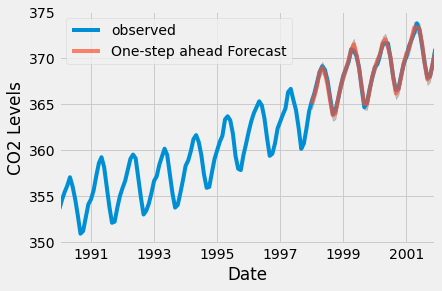

In [21]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':] # Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 0.07


In [23]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

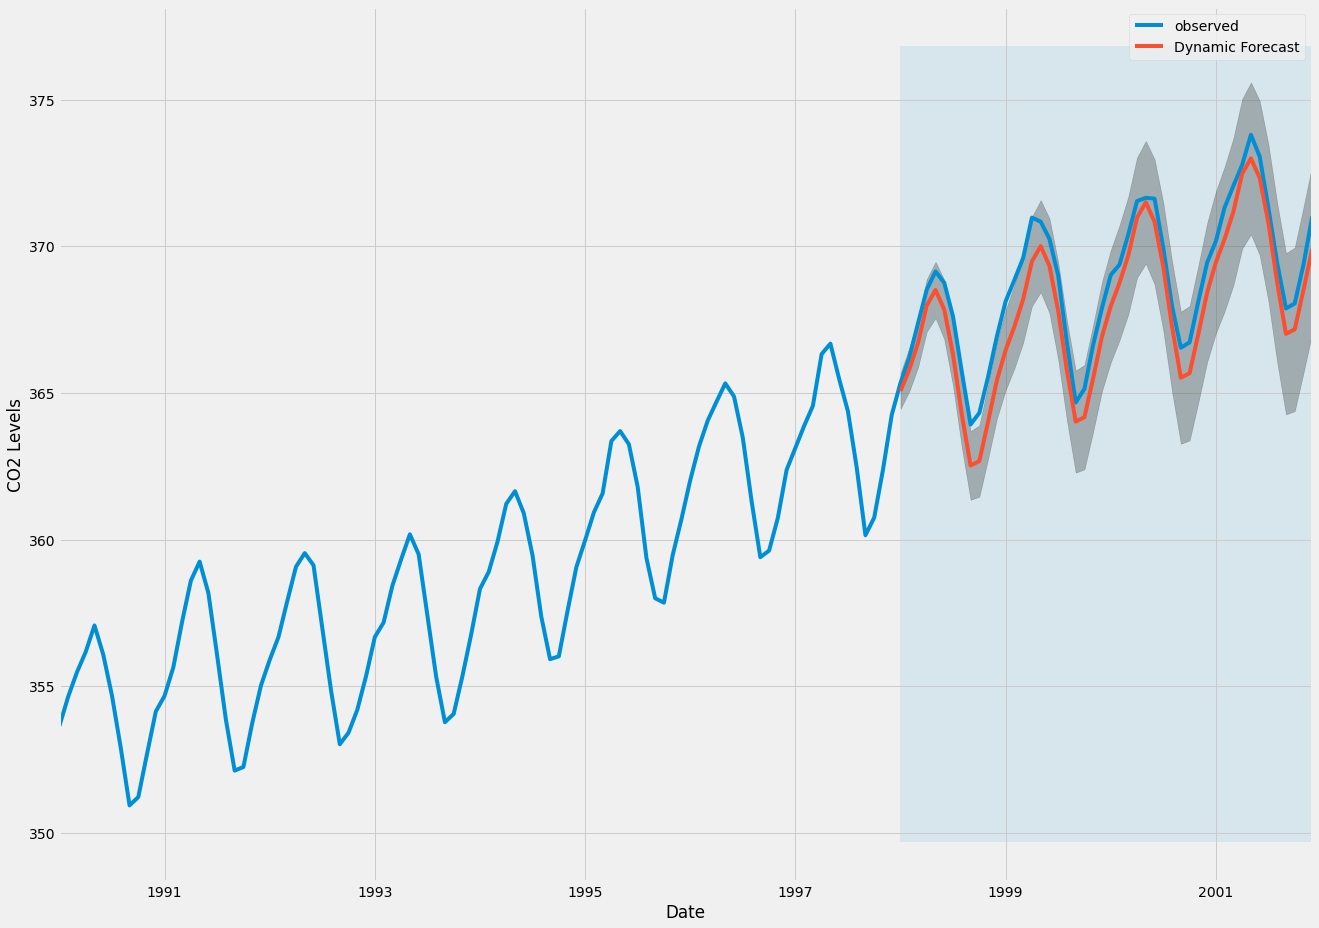

In [24]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
pred_dynamic_ci.iloc[:, 0],
pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

In [25]:
# Извлечь прогнозируемые и истинные значения временного ряда
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':] # Вычислить среднеквадратичную ошибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 1.01


In [26]:
# Получить прогноз на 500 шагов вперёд
pred_uc = results.get_forecast(steps=500)
# Получить интервал прогноза
pred_ci = pred_uc.conf_int()

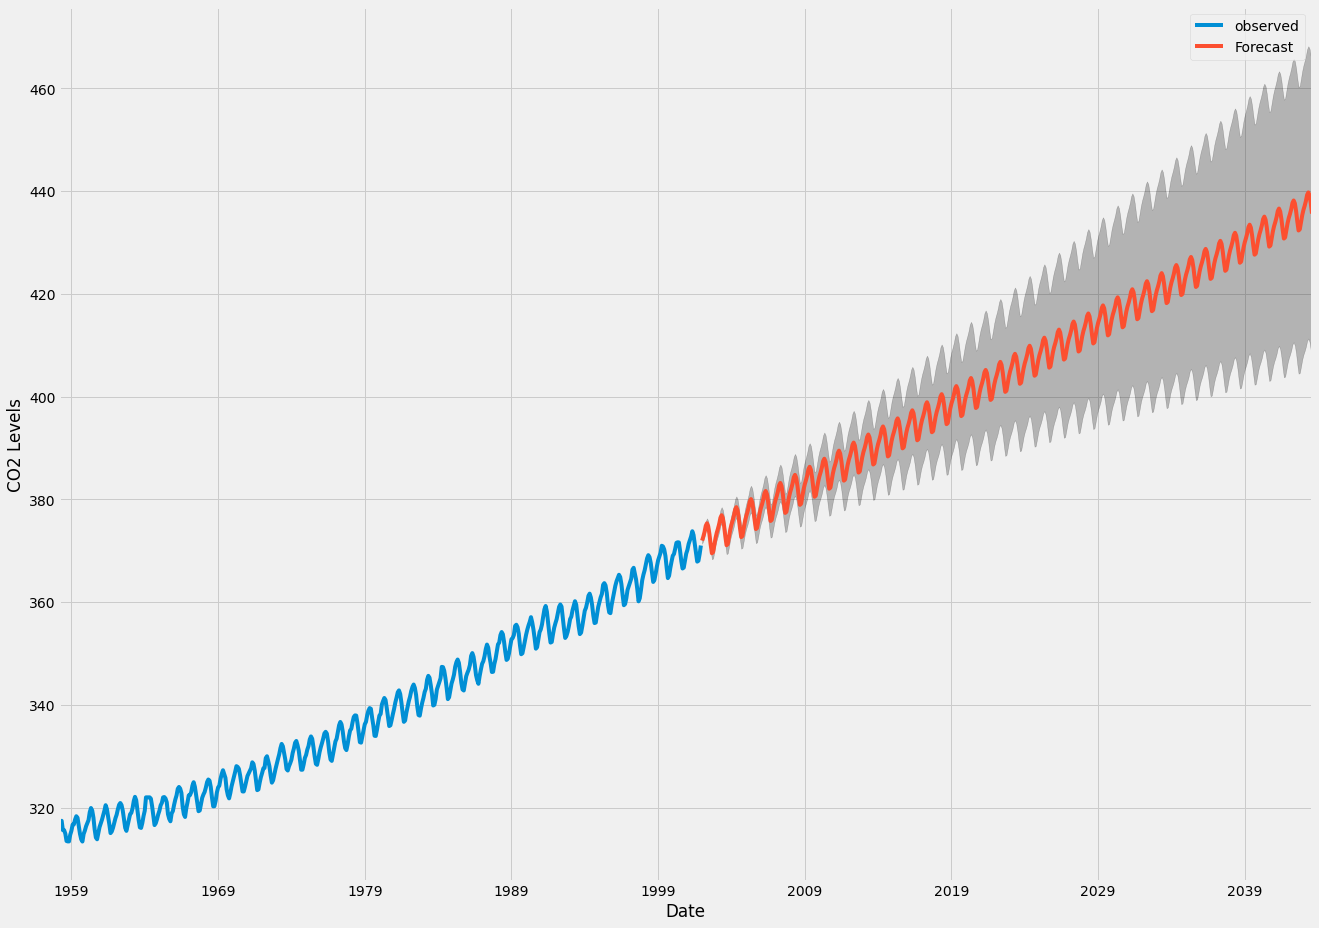

In [27]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
pred_ci.iloc[:, 0],
pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()